## Example Drifter data handling 
### Agulhas retroflection region
The Atlantic and Indian Ocean meet around South Africa, and this is one of the most dynamic and energetic regions in the world ocean. The Agulhas retroflection is a region where the Agulhas current retroflects back into the Indian Ocean. This region is known for its strong currents and eddies, and is a region where many drifters have been deployed.

In this tutorial, we will explore virtual drifters deployed in the Agulhas Current, just off the city of Durban at 31S. The virtual drifters report their position every hour, and have a lifetime of 30 days. 

In [1]:
from virtualship.models import Location, Spacetime
from virtualship.instruments.drifter import Drifter, simulate_drifters
from virtualship.expedition.input_data import InputData
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import trajan
from datetime import timedelta

We have downloaded the data from Copernicus Marine Service, using `virtualship fetch` and the information in following yaml format:
```yaml
area_of_interest:
  spatial_range:
    minimum_longitude: 5
    maximum_longitude: 60
    minimum_latitude: -45
    maximum_latitude: -30
    minimum_depth: -30
    maximum_depth: 0
  time_range:
    start_time: 2023-07-01 00:00:00
    end_time: 2023-09-30 00:00:00
```

We have stored this hydrodynamic data in an `expedition_directory`, from which we can launch the virtual drifters. But before we do this, we will first need to load the data into a Parcels `FieldSet`.

In [2]:
expedition_directory = Path("/Users/erik/Desktop/VSC_AgulhasDrifters")
fieldset = InputData._load_ship_fieldset(expedition_directory)

We will programatically create a list of 20 drifters to be deployed, using the `Drifter` Class. The 10 drifters are launched on a line from (31S, 31E) to (31S, 32E) and between 2 and 21 July 2023, one each day at midnight.

In [3]:
vs_drifters = []
for i, lon in enumerate(np.linspace(31, 32, 20)):
    vs_drifters.append(
        Drifter(
            Spacetime(
                Location(latitude=-30, longitude=lon),
                time=np.datetime64(f"2023-07-{i + 2:02d} 00:00:00"),
            ),
            depth=0.0,
            lifetime=timedelta(days=90),
        )
    )

We will now simulate the drifters for 90 days and store their trajectories in a `drifters.zarr` file.

In [4]:
out_path = f"{expedition_directory}/drifters.zarr"
simulate_drifters(
    fieldset,
    out_path,
    vs_drifters,
    outputdt=timedelta(hours=1),
    dt=timedelta(minutes=30),
    endtime=None,
)

INFO: Output files are stored in /Users/erik/Desktop/VSC_AgulhasDrifters/drifters.zarr.
WARN: Some drifters had a life time beyond the end time of the fieldset or the requested end time.


The simplest way to plot these trajectories is to use the [TrajAn package](https://opendrift.github.io/trajan/). As you see below, the drifters all start in the Agulhas Current (red dots at 30S) and most are initially advected southwestwards (although some first move northeastwards). At least two drifters take a path farther offshore, where their trajectories are much more eddying. When the inshore drifters reach approximately 25E, some of them start to circulate in eddies, and their tracks become even more convoluted.

/Users/erik/anaconda3/envs/parcels/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
No time or obs dimension detected.


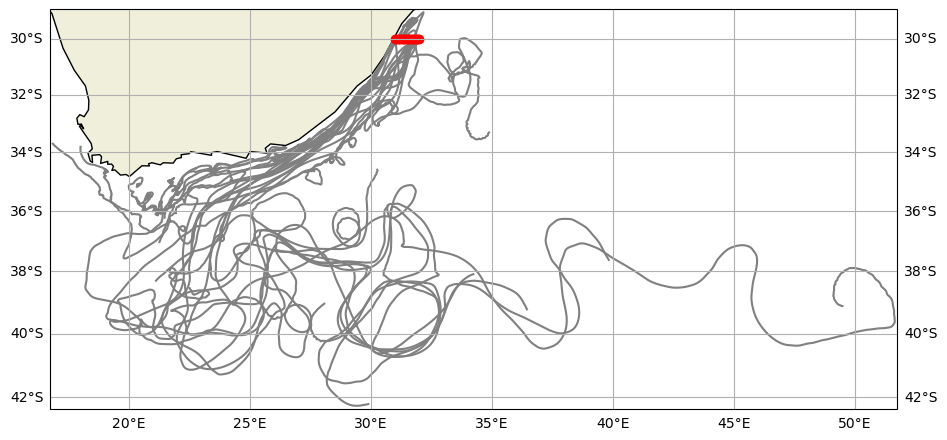

In [5]:
ds = xr.open_zarr(out_path)
ds.traj.plot()
ds.isel(obs=0).traj.plot("o", color="r")
plt.show()

One potentially interesting analysis could be to compare the starting longitude to the final longitude. Do the drifters that start on the inshore side of the Agulhas Current have a higher chance to end up in the Atlantic Ocean (aka Agulhas leakage) than the drifters that start on the offshore side?

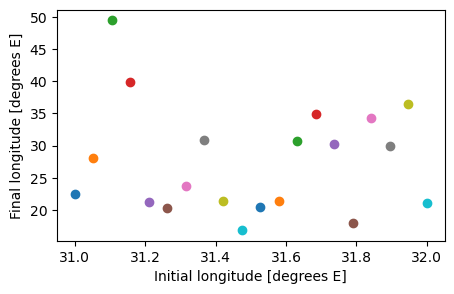

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

for i in range(len(ds.lon)):
    last_non_nan_index = np.max(np.where(~np.isnan(ds.lon[i, :])))
    ax.plot(ds.lon[i, 0], ds.lon[i, last_non_nan_index], "o")
ax.set_xlabel("Initial longitude [degrees E]")
ax.set_ylabel("Final longitude [degrees E]")
plt.show()

How do you interpret this plot? Is it what you expected? What other analyses could be interesting to do with this data?